# Using linear revolution invariance (LRI) 

This is a notebook which will show you how to generate and deblur the output of a linear revolution-invariant (i.e., rotationally-symmetric) imaging system. These methods were devoloped in [Linear Revolution-Invariance: Modeling and Deblurring Shift-Varying Imaging Systems](https://arxiv.org/abs/2206.08928).

In particular, there are only really 2 main functions of use: blur and deblur; they do exactly as their names suggest. Both require a radial stack of PSFs from the system to compute which can be gotten from the calibrate function, which takes in a single calibration image. That is, LRI blurring and deblurring requires only a calibration single image from the system of interest---one that contains a few randomly scattered PSFs.

The process goes as follows: 
1. Obtain a calibration image of a few point sources from your imaging system (or directly get its Seidel coefficients)

2. Plug in the calibration image into ```calibrate``` which returns a radial stack of rotationally fourier transforms of PSFs

3. Pass in the PSF stack and your image of interest to either ```blur``` or ```deblur``` and get back the corresponding result.


## Setup

First things first, let's get set up with out imports and figure out GPU useage. Note that we make the GPU use optional but it does speed up the algorithms.

In [1]:
from functions import * # here we import our 3 main functions: calibrate, blur, and deblur

# here are some basics we will need
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize
from PIL import Image

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print('Using ' +str(device) + ' for computation')

Using cuda:0 for computation


## Calibrating

The necessary calibration image is a single image with a few randomly scattered PSFs. For example, here we use an image of a glass slide with a streak of random fluorescent beads taken with the [UCLA Miniscope v3](http://miniscope.org/index.php/Main_Page). Our procedure iteratively searches for Seidel coefficients which have PSFs that match those in the calibration image. There are default optimization parameters for this search in ```calibrate``` however the user may specify them with a dictionary (see code for arguments). This is a one time cost per imaging system as it is possible to store the PSF stack or Seidel coefficients for future use.

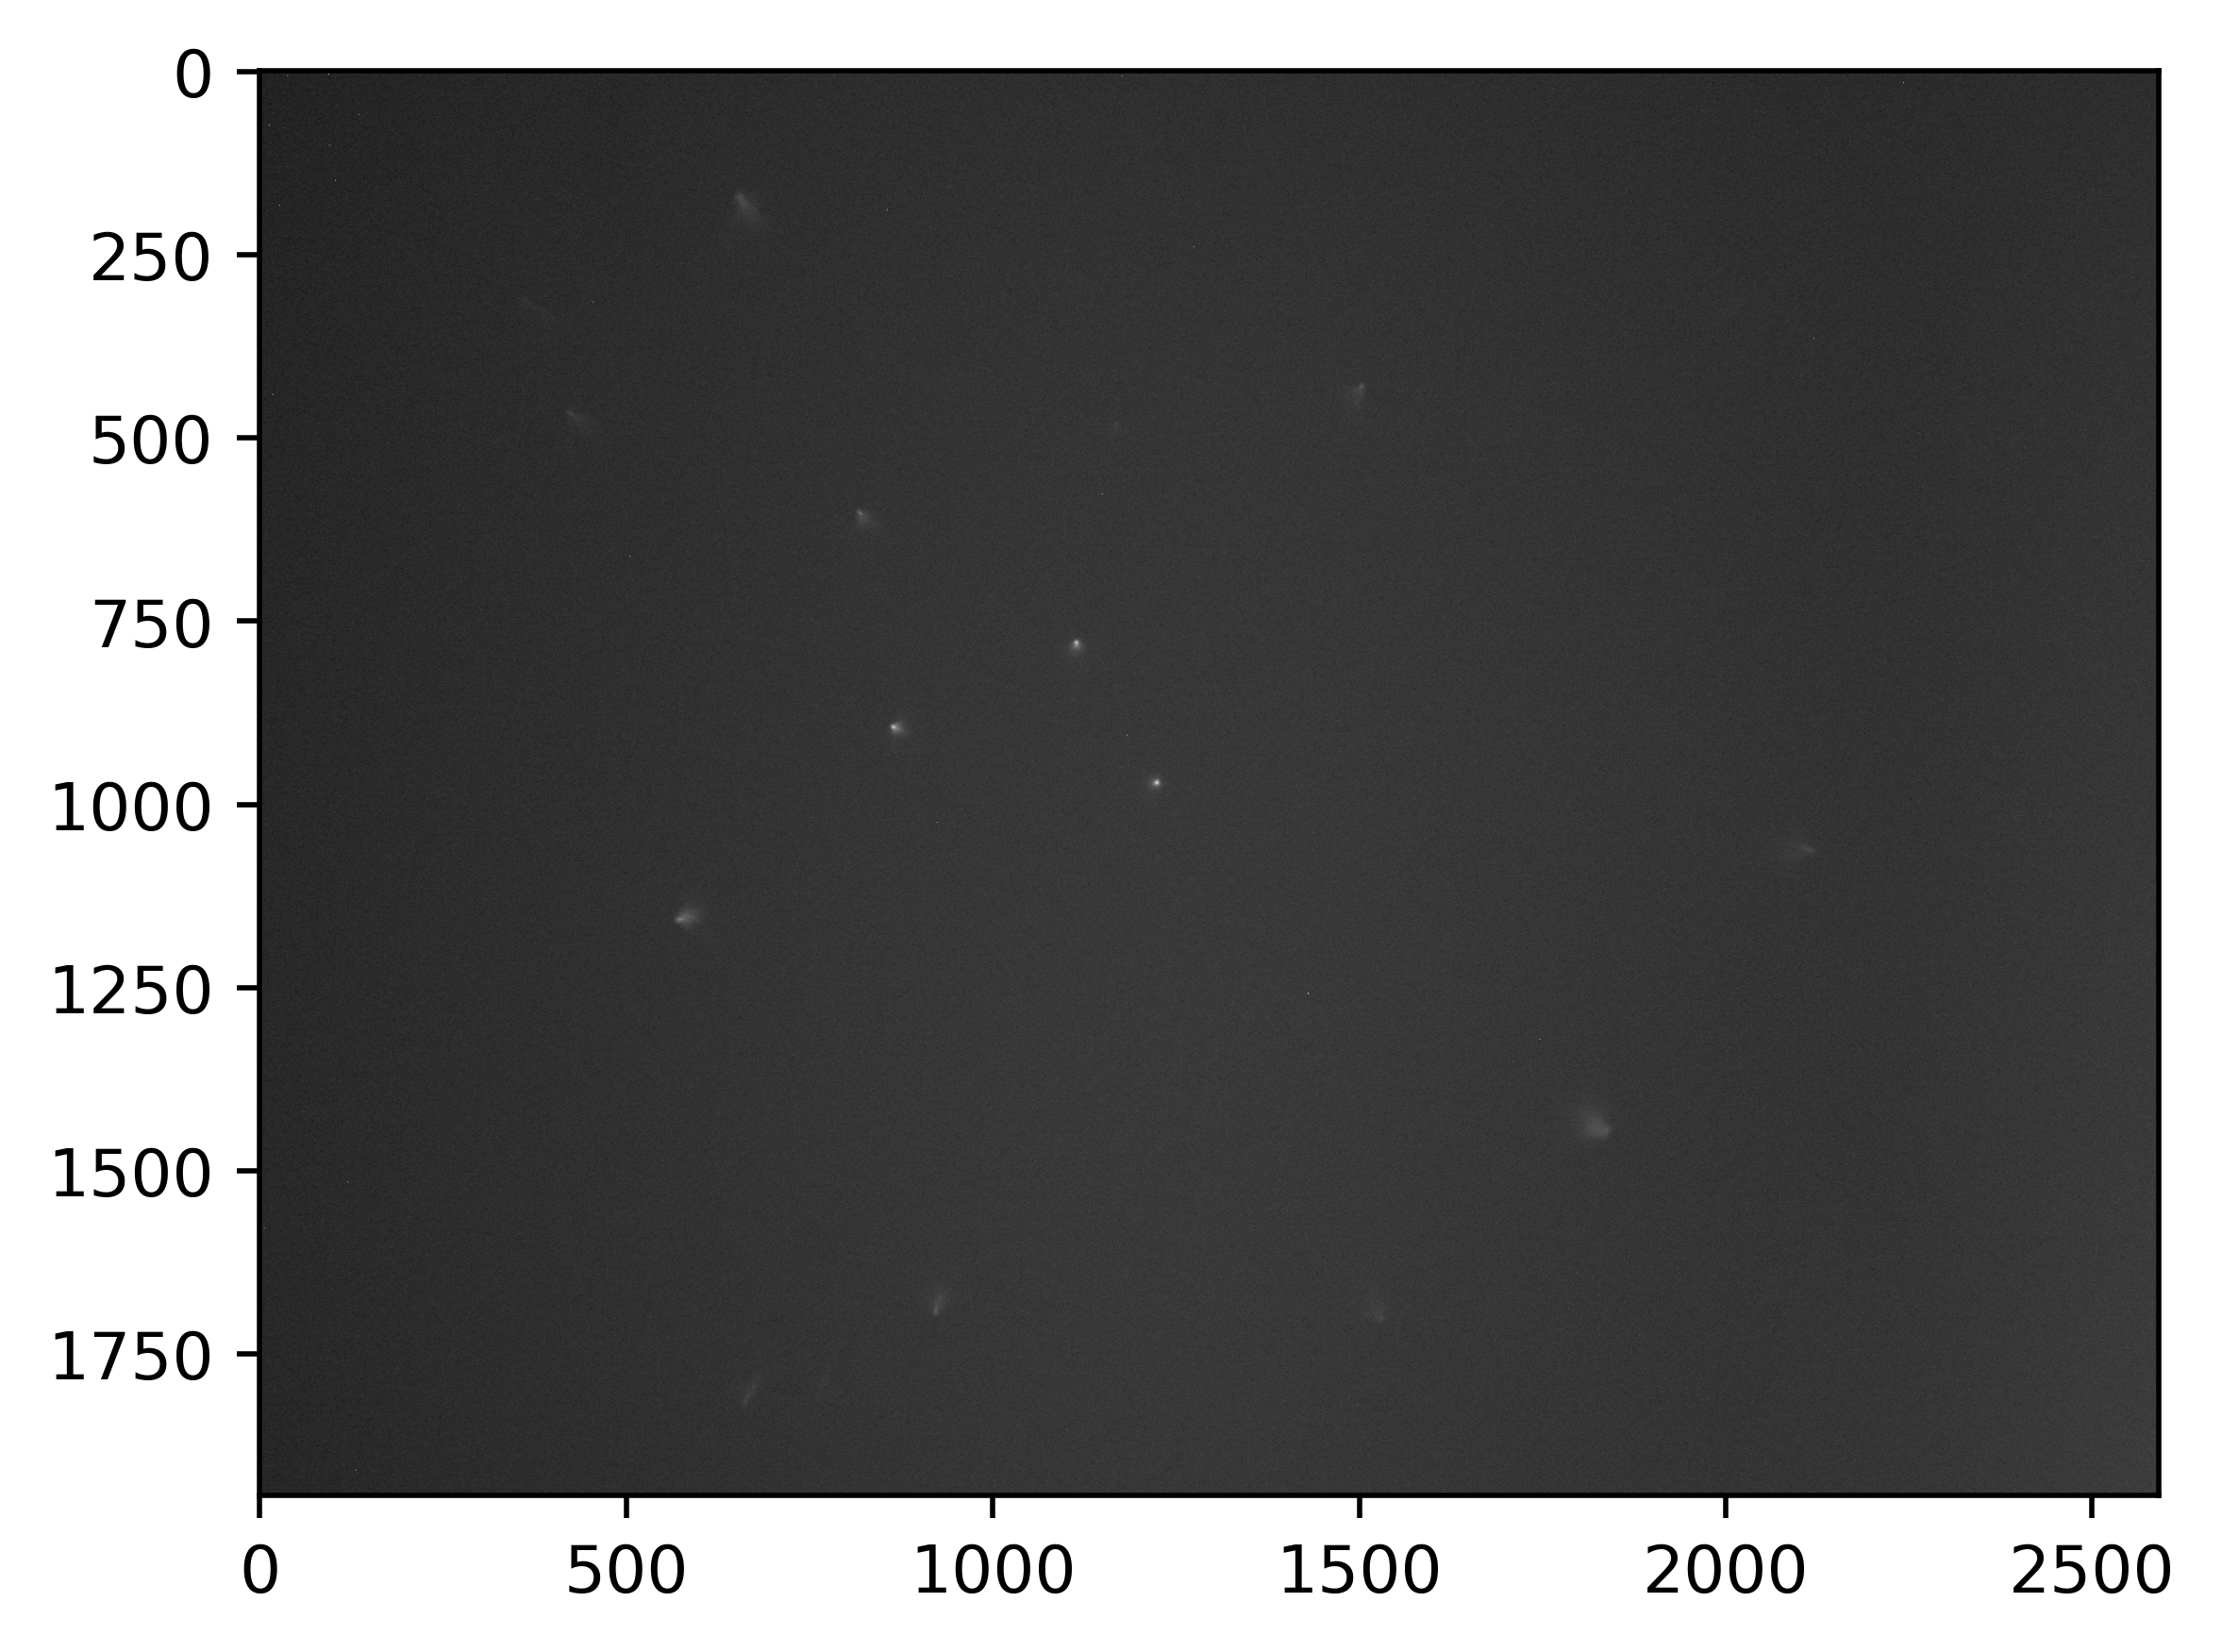

In [2]:
# First read in and display the calibration image (in log scale so you can see the PSFs!)
calibration_image = np.array(Image.open('test_images/calibration_image.tif'))
util.show((calibration_image)**(1/2))

In [3]:
# now we calibrate and get our PSF stack (note this is a one time cost!)

# this dim specifies the size of the images we are dealing with, they ought to be square (i.e., dim x dim)
dim=1024

# we can choose to tradeoff speed and accuracy using num_psfs, which determines how many PSFs we sample.
num_psfs = 512 # here we will choose half the usual dim number of PSFs because it doubles the speed and is still effective

# this is a test image
baboon = resize(io.imread('test_images/baboon.png'), [dim, dim])

# the optimization parameters for the coefficient search
opt_params = {'iters': 300, 'lr': 7.5e-3, 'reg': 0}

# a good pair of seidel coeffs if you don't want to run the fitting procedure
seidel_coeffs = [0, -0.9105, 0.0549, -0.6531, 0, 0]

# here we get our PSF stack (in practice we recommend cacheing this). For now restricted to only the first 3 seidel coeffs
psf_stack_roft, seidel_coeffs = calibrate(calibration_image, seidel_coeffs=None, desired_dim=dim, num_psfs=num_psfs, opt_params=opt_params, device=device)

print('seidel coeffs: ', seidel_coeffs.cpu().detach().numpy())

estimating seidel coefficients...


  0%|          | 0/512 [00:00<?, ?it/s]

computing radial stack of PSFs...


100%|██████████| 512/512 [01:01<00:00,  8.38it/s]


seidel coeffs:  [[ 0.        ]
 [-0.9586084 ]
 [ 0.19724369]
 [-0.736138  ]
 [ 0.        ]
 [ 0.        ]]


## LRI forward modeling (i.e., blurring)

With the calibration complete, we now have access to the radial stack of PSFs needed to compute the LRI forward model. Here we demonstrate our implementation of the model through the ```blur``` function.

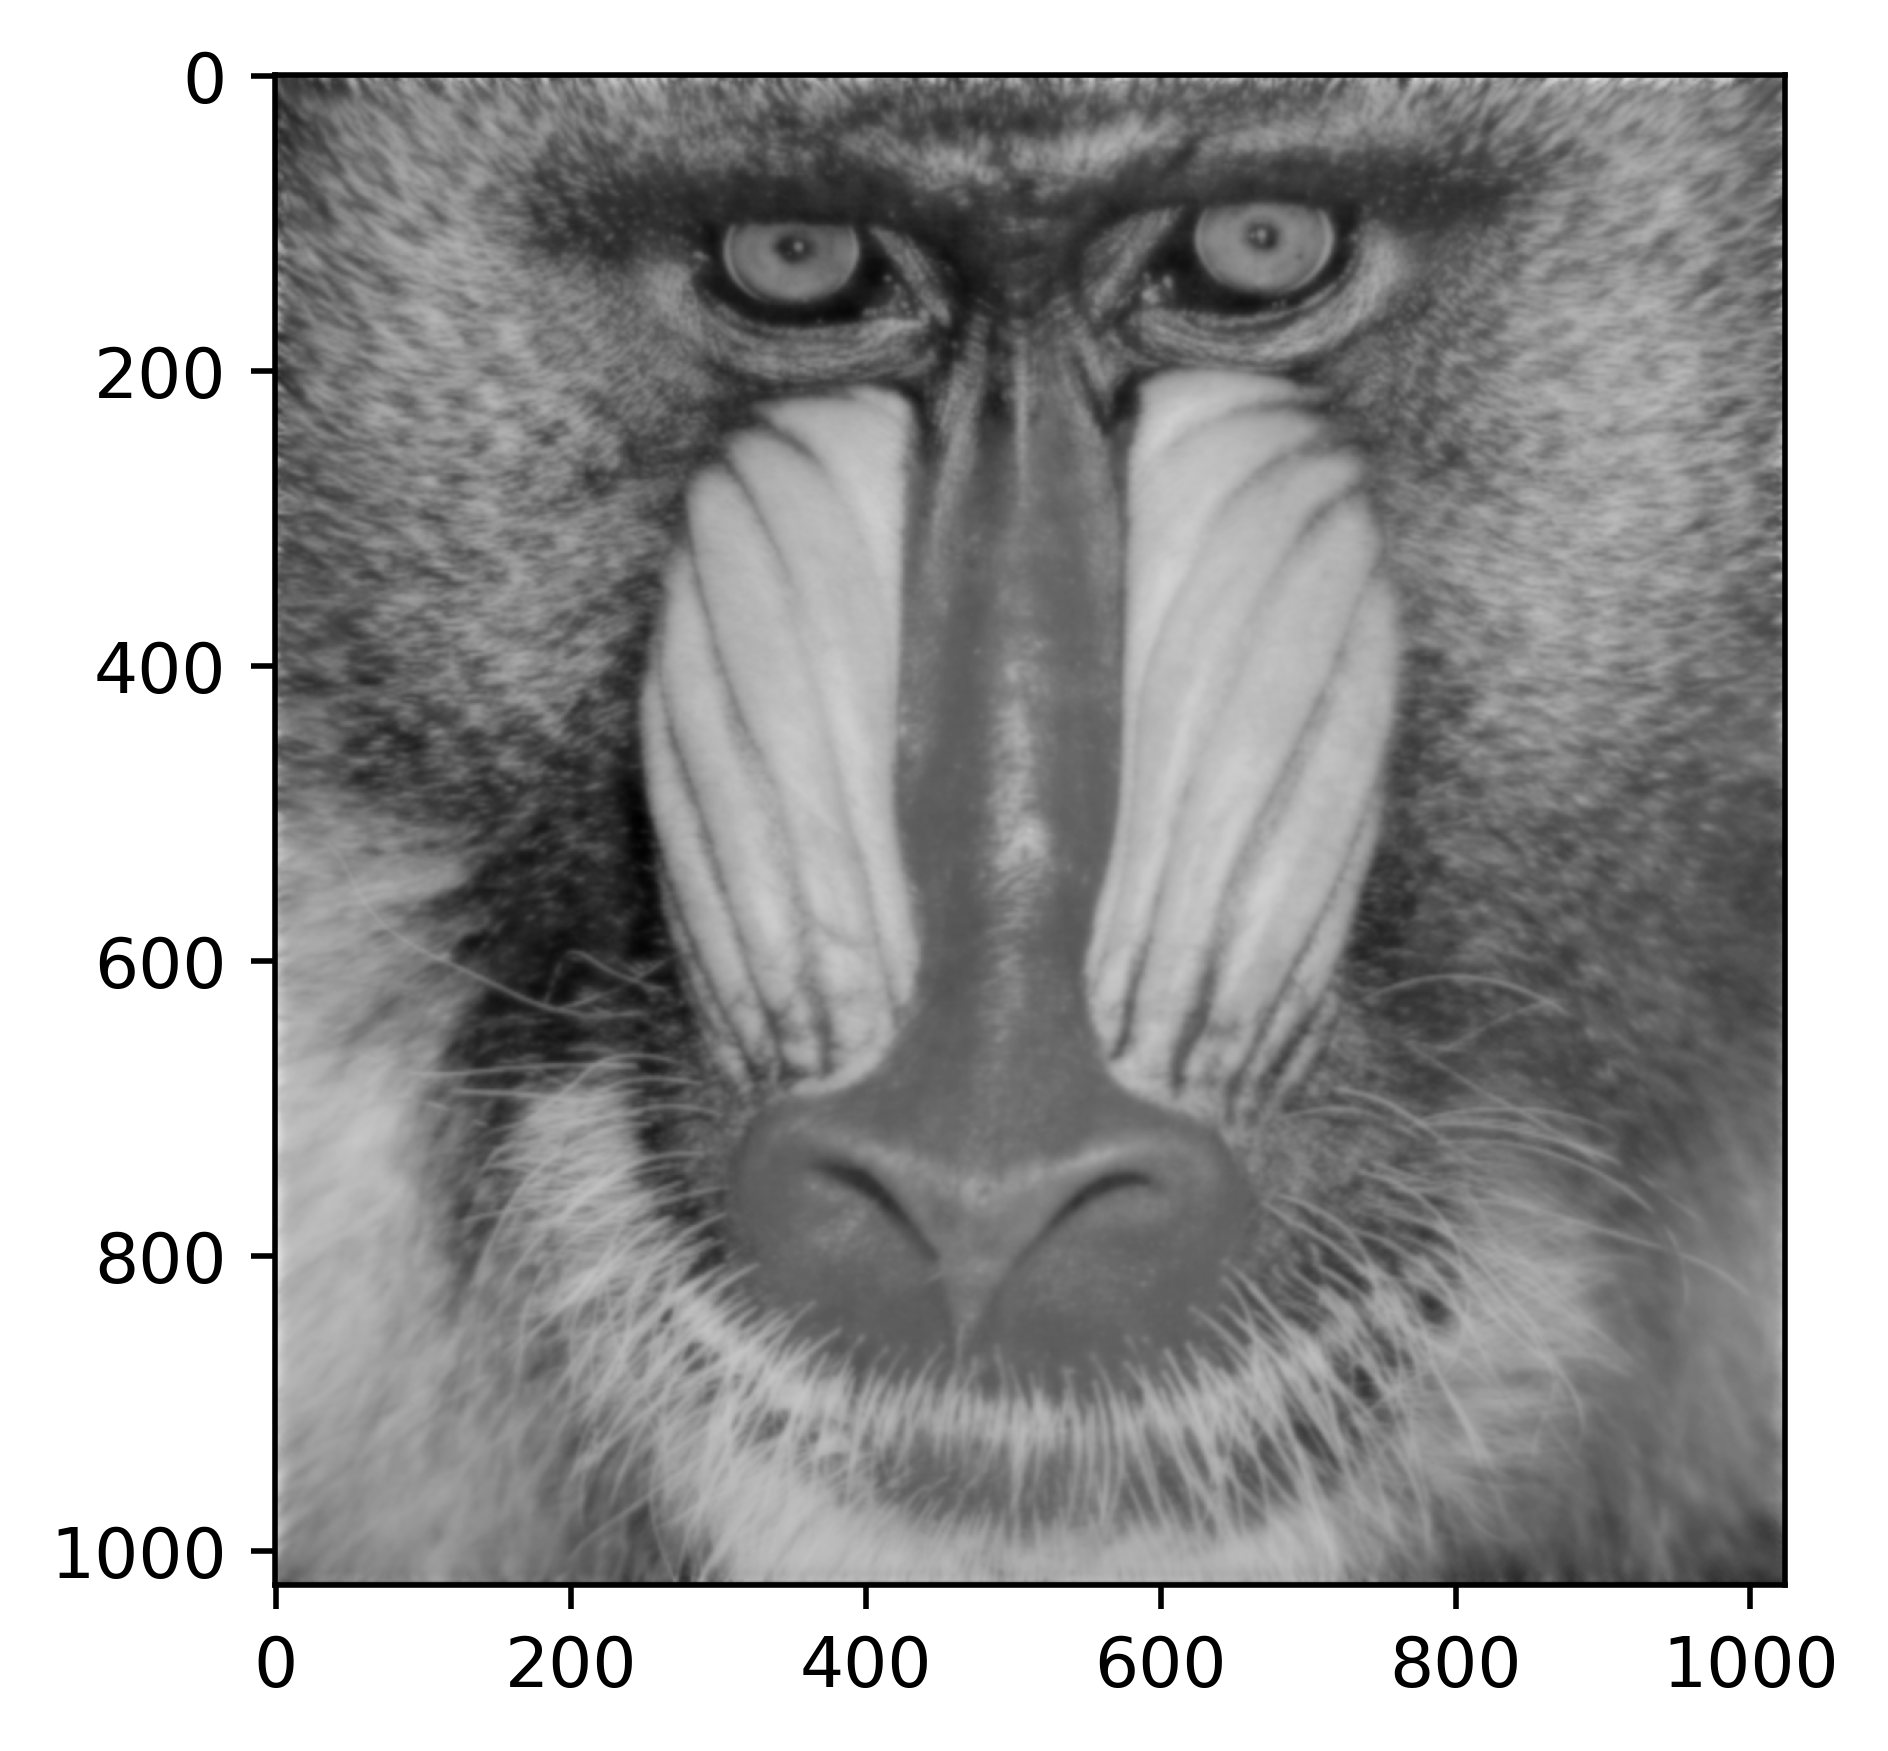

In [4]:
# we can pick the strength of artifact correction to help deal with the effects of finite sampling
artifact_correction = 0.2

# now we run the LRI forward model on the test image using the psf stack
blurry_baboon = blur(baboon, psf_stack_roft, artifact_correction=artifact_correction, device=device)

util.show(blurry_baboon.detach().cpu())

## LRI deblurring

Now we get to using LRI for image deblurring. Since deblurring amounts to inverting the forward model we only need the same PSF stack we used for blurring. We implement it with the ```deblur``` function. 

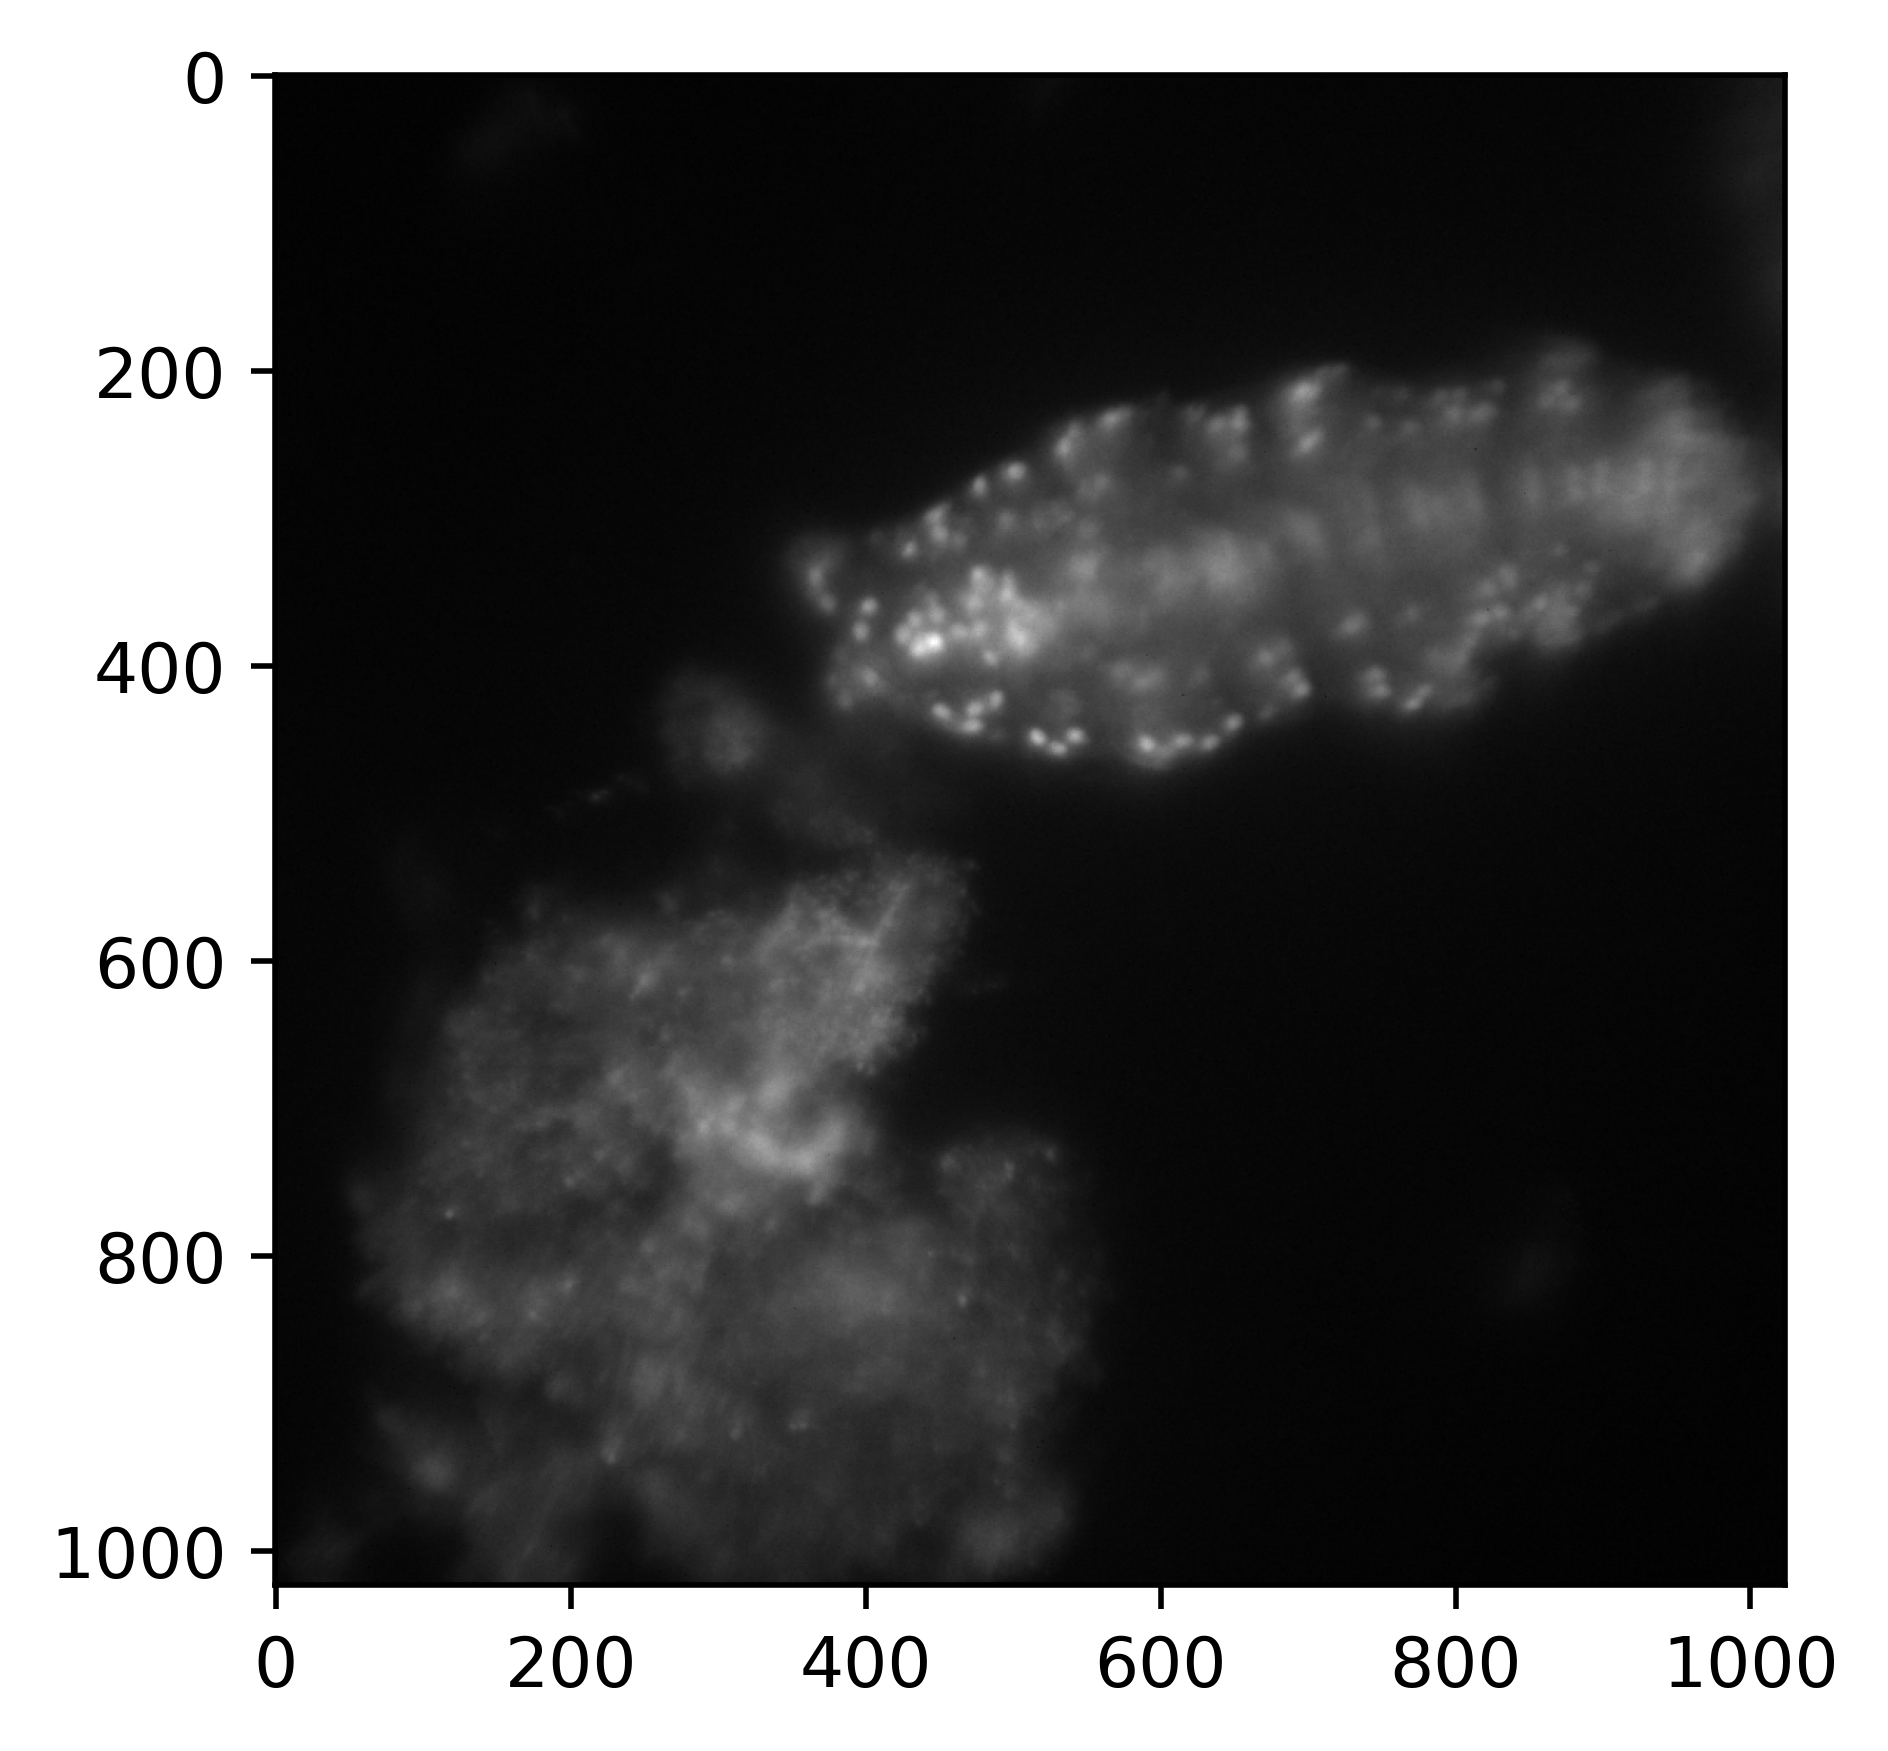

In [5]:
# first lets read in and view a blurry waterbear image taken from the same system as the calibration image
waterbear = resize(io.imread('test_images/measurement.png')[:,:,0], [dim,dim])
waterbear = util.center_crop(waterbear, (dim,dim))
waterbear = util.normalize(waterbear)
util.show(waterbear)


100%|██████████| 300/300 [01:04<00:00,  4.68it/s]


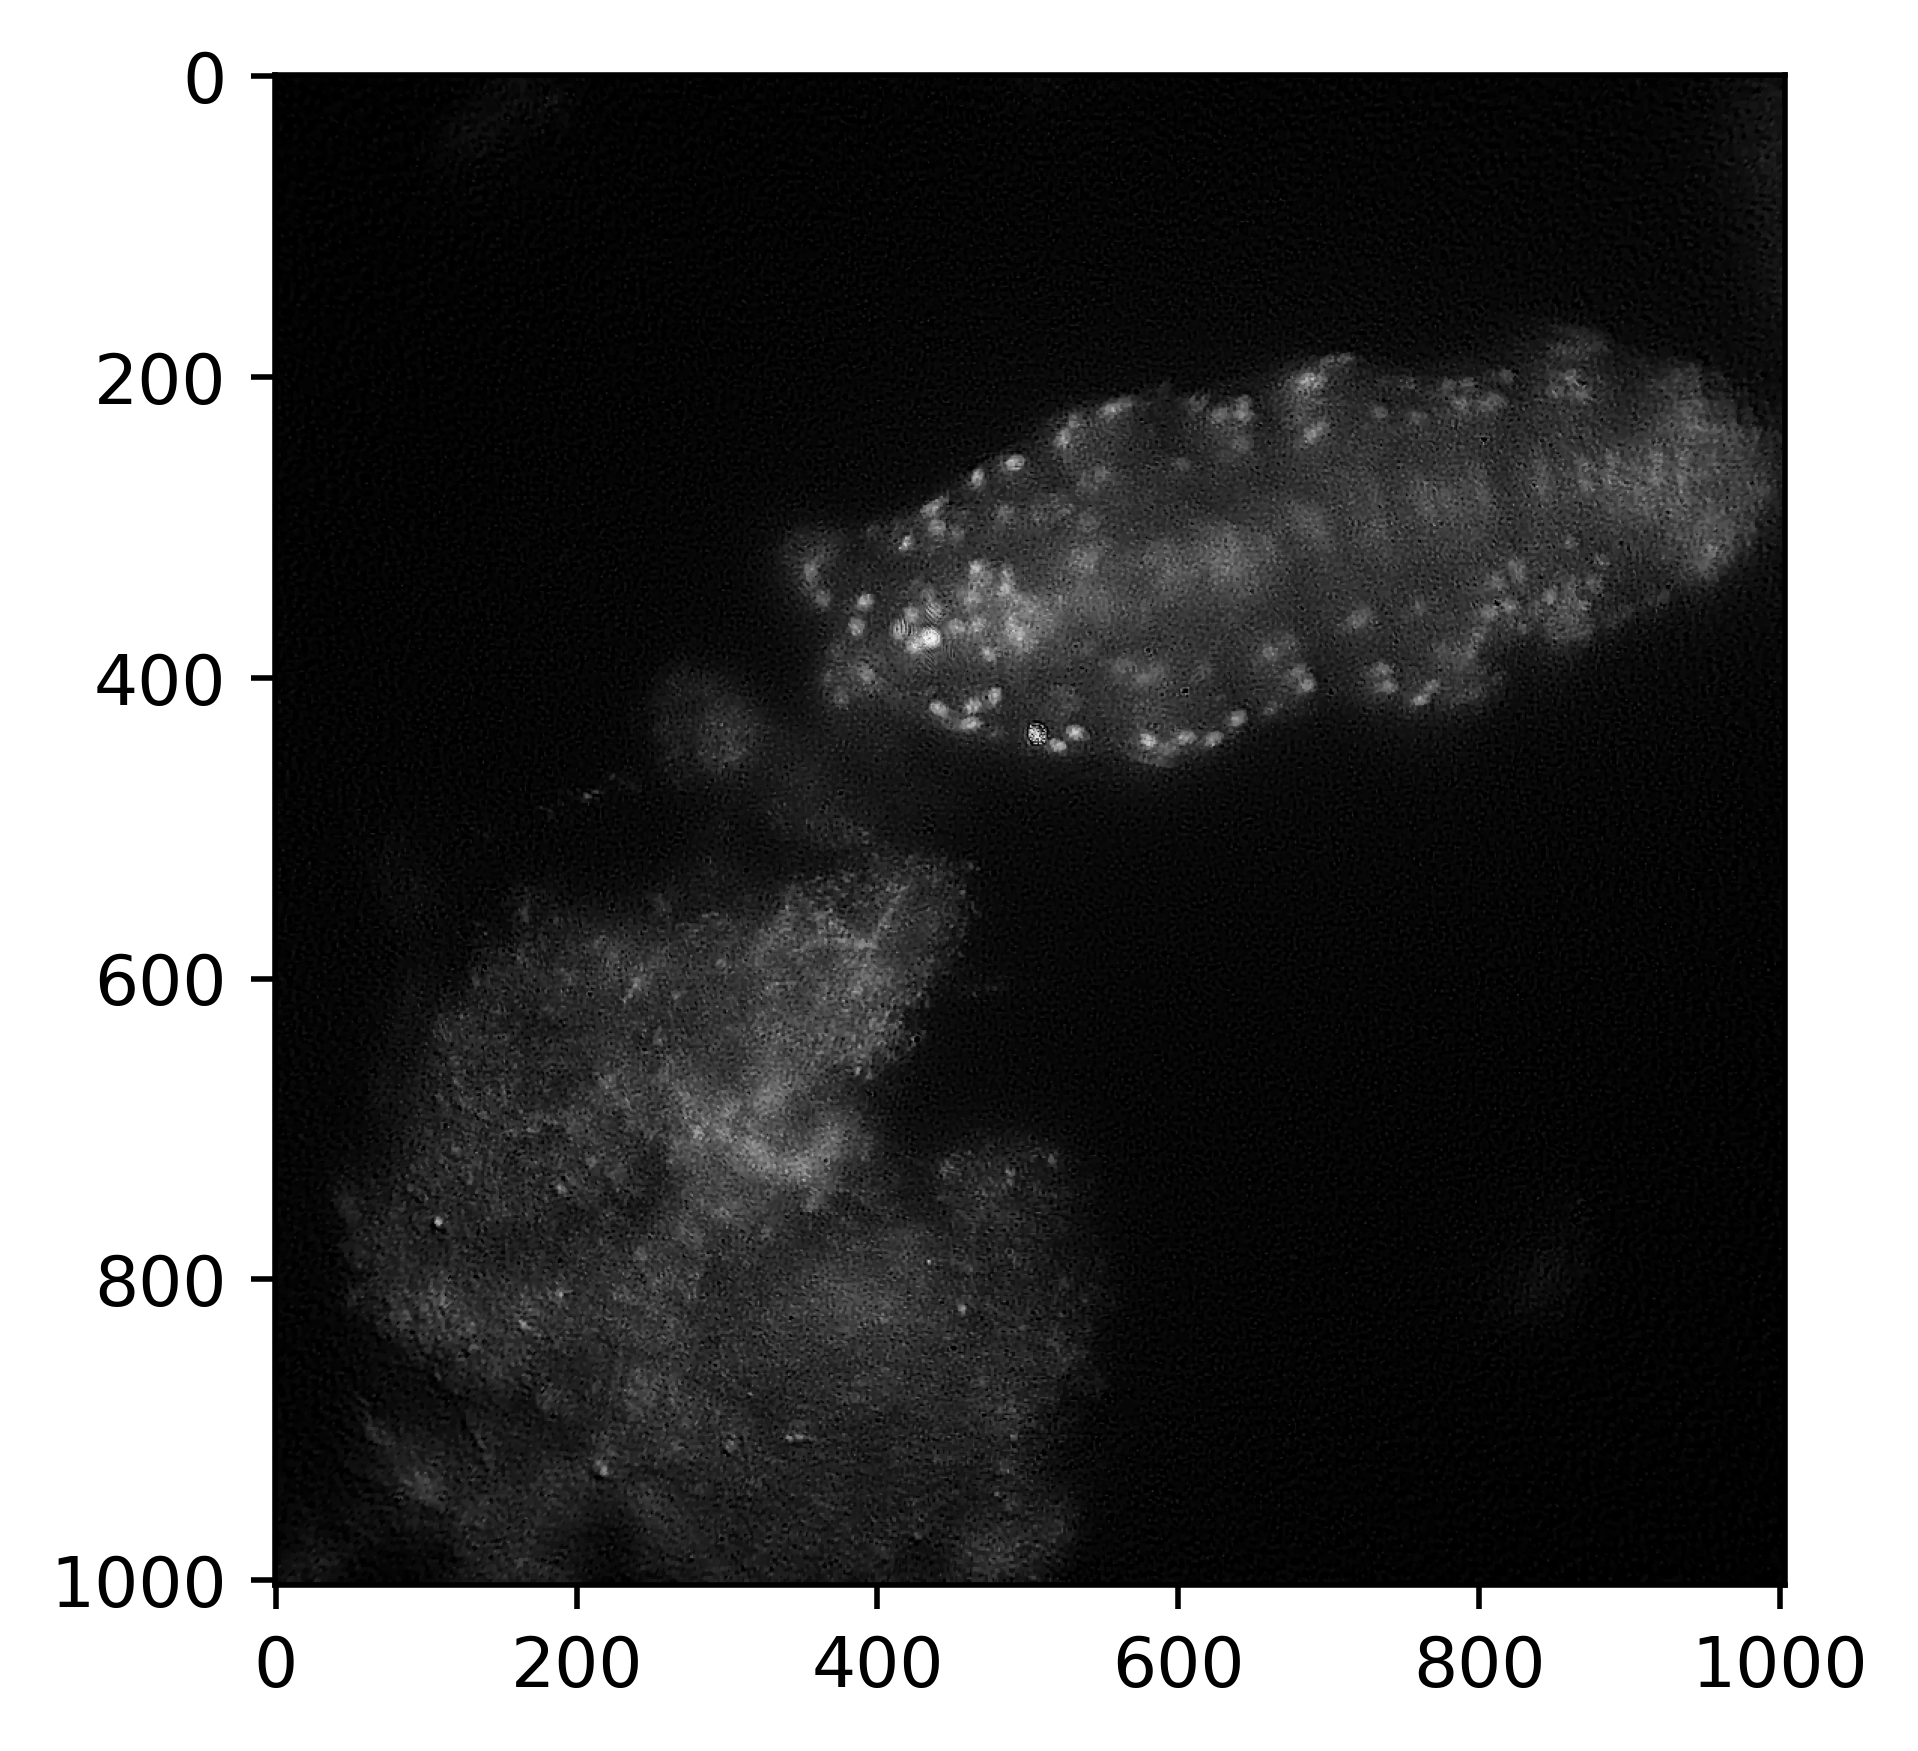

In [6]:
# now for deblurring we need to specify the optimization parameters. 
# Crop controls how much of the image border to ignore, reg controls total variation regularization.
crop = 10
opt_params = {'iters': 300, 'optimizer': 'adam', 'lr': 7.5e-2, 'init': 'measurement', 'crop': crop, 'reg': 7.5e-11}

# choose artifact correction strength
artifact_correction = 0

# finally we apply the deblurring
deblurred_waterbear = deblur(waterbear, psf_stack_roft, opt_params=opt_params, artifact_correction=artifact_correction, device=device)
util.show(deblurred_waterbear[crop:-crop, crop:-crop])